<a href="https://colab.research.google.com/github/BlaiseMarvin/FaceRecognitionPaymentSystem/blob/main/FaceNetTrainingArcFaceLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The Arcface loss class

In [2]:
import math as m

import numpy as np
from tqdm import tqdm
import math
import os

import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import layers
from tensorflow.keras import Model 


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow



class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



In [4]:
import os
from os import listdir

path="/content/drive/MyDrive/NewDataset/Aligned/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Renal count:  26
Name:  Ruth count:  17
Name:  Remuneration count:  63
Name:  Salvador count:  35
Name:  Sandra count:  35
Name:  Vanny count:  30
Name:  Peterson count:  44
Name:  Samson count:  64
Name:  Raymond count:  18
Name:  Pesh count:  42
Name:  Ntale count:  37
Name:  Onyango count:  36
Name:  Owor count:  46
Name:  Nabata count:  46
Name:  Mbonye count:  60
Name:  Namubiru count:  50
Name:  Mcvex count:  48
Name:  Menk count:  52
Name:  Nabwiso count:  55
Name:  Nduhukire count:  53
Name:  KenMugabi count:  48
Name:  Marcus count:  43
Name:  Malaika count:  55
Name:  Maurice count:  32
Name:  Lynda count:  46
Name:  Katatumba count:  61
Name:  Lucky count:  57
Name:  Martha count:  38
Name:  Maritza count:  62
Name:  Lydia count:  71
Name:  Kanyomozi count:  77
Name:  Katamba count:  36
Name:  Kansiime count:  32
Name:  Julian count:  63
Name:  Judithiana count:  50
Name:  Kabuura count:  23
Name:  Karungi count:  41
Name:  GNL count:  25
Name:  Jazmine count:  51
Nam

In [5]:
import os
from os import listdir

path="/content/drive/MyDrive/NewDataset/AlignedVal/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Vanny count:  13
Name:  Sandra count:  9
Name:  Peterson count:  10
Name:  Remuneration count:  19
Name:  Renal count:  7
Name:  Samson count:  21
Name:  Pesh count:  11
Name:  Ruth count:  6
Name:  Salvador count:  8
Name:  Owor count:  9
Name:  Raymond count:  4
Name:  Onyango count:  7
Name:  Namubiru count:  9
Name:  Nduhukire count:  8
Name:  Nabata count:  20
Name:  Ntale count:  8
Name:  Mbonye count:  13
Name:  Nabwiso count:  19
Name:  Maurice count:  6
Name:  Mcvex count:  7
Name:  Menk count:  10
Name:  Martha count:  6
Name:  Katatumba count:  19
Name:  KenMugabi count:  8
Name:  Lucky count:  16
Name:  Malaika count:  10
Name:  Maritza count:  12
Name:  Katamba count:  10
Name:  Marcus count:  8
Name:  Lynda count:  7
Name:  Lydia count:  11
Name:  Karungi count:  7
Name:  Kabuura count:  6
Name:  Jazmine count:  9
Name:  Kabareebe count:  9
Name:  Kansiime count:  7
Name:  GNL count:  7
Name:  Julian count:  10
Name:  Judithiana count:  12
Name:  Kanyomozi count:  

#### Setting up the Image Data Generator API

In [6]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="/content/drive/MyDrive/NewDataset/Aligned/"
VALIDATION_DIR="/content/drive/MyDrive/NewDataset/AlignedVal/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,class_mode='categorical',target_size=(160,160), shuffle=False)
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,class_mode='categorical',target_size=(160,160), shuffle=False, batch_size=1)

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 2659 images belonging to 59 classes.
Found 603 images belonging to 59 classes.


## Loading the facenet Model architecture

In [7]:
model=load_model('/content/drive/MyDrive/facenet_keras (1).h5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [8]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [9]:
local_weights_file='/content/drive/MyDrive/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [10]:
#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

In [11]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [12]:
#Code from arcface repo

#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(arcface_output)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(59,activation='softmax')(arcface_output)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [13]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

In [15]:
checkpoint_filepath= '/content/drive/MyDrive/Extracted/Model'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [16]:
#training for 500 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=500,verbose=2, callbacks=[reduce_lr,early,model_checkpoint_callback])

Epoch 1/500
84/84 - 1313s - loss: 4.0820 - accuracy: 0.0158 - auc: 0.4991 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0620 - val_accuracy: 0.0299 - val_auc: 0.5295 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/500
84/84 - 16s - loss: 4.0588 - accuracy: 0.0188 - auc: 0.5366 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0422 - val_accuracy: 0.0299 - val_auc: 0.5589 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/500
84/84 - 16s - loss: 4.0383 - accuracy: 0.0308 - auc: 0.5657 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0224 - val_accuracy: 0.0431 - val_auc: 0.5868 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/500
84/84 - 16s - loss: 4.0175 - accuracy: 0.0451 - auc: 0.5953 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.0031 - val_accuracy: 0.0597 - val_auc: 0.6177 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/500
84/84 - 16s - loss: 3.9970 - accuracy: 0.0700 - auc: 0.6236 - reca

### Lets visualize the output of the training phase

## 413 from 426

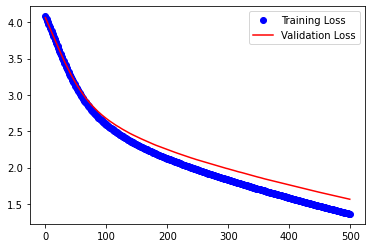

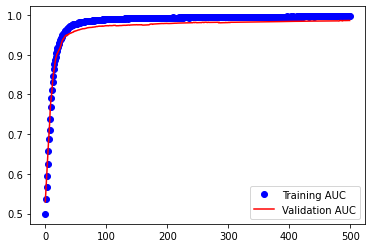

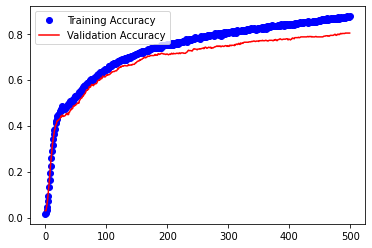

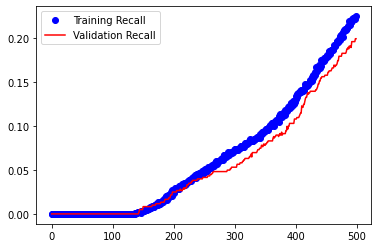

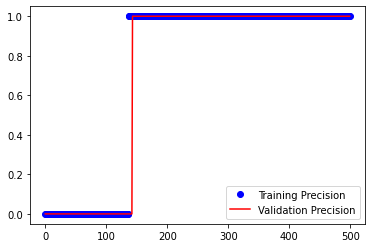

In [17]:
auc=history.history['auc']
val_auc=history.history['val_auc']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

recall=history.history['recall']
val_recall=history.history['val_recall']

precision=history.history['precision']
val_precision=history.history['val_precision']

epochs=range(len(acc))

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs,recall,'bo',label="Training Recall")
plt.plot(epochs,val_recall,'r',label="Validation Recall")
plt.legend()
plt.show()

plt.plot(epochs,precision,'bo',label="Training Precision")
plt.plot(epochs,val_precision,'r',label="Validation Precision")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [19]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

In [20]:
predict = model.predict_generator(validation_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [21]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[10  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  5]]


In [22]:
target_names=list(training_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Abenaki       1.00      1.00      1.00        10
        Alex       1.00      1.00      1.00         4
       Aloyo       1.00      0.75      0.86        12
       Apass       1.00      0.14      0.25         7
  Babygloria       0.80      0.89      0.84         9
      Barbie       1.00      0.67      0.80         3
       Becky       1.00      0.90      0.95        10
     Bettina       0.80      0.86      0.83        14
       Brian       0.83      1.00      0.91         5
      Canary       0.88      0.94      0.91        16
       Cindy       0.93      0.88      0.90        16
   Cleopatra       1.00      0.80      0.89        10
      Daniel       1.00      1.00      1.00        17
      Desire       0.91      1.00      0.95        21
       Diana       0.38      1.00      0.55         9
     Dorothy       0.00      0.00      0.00         3
       Farid       0.68      1.00      0.81        17
         GNL       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
!pip install scikit-plot

In [24]:
import scikitplot as skplt
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

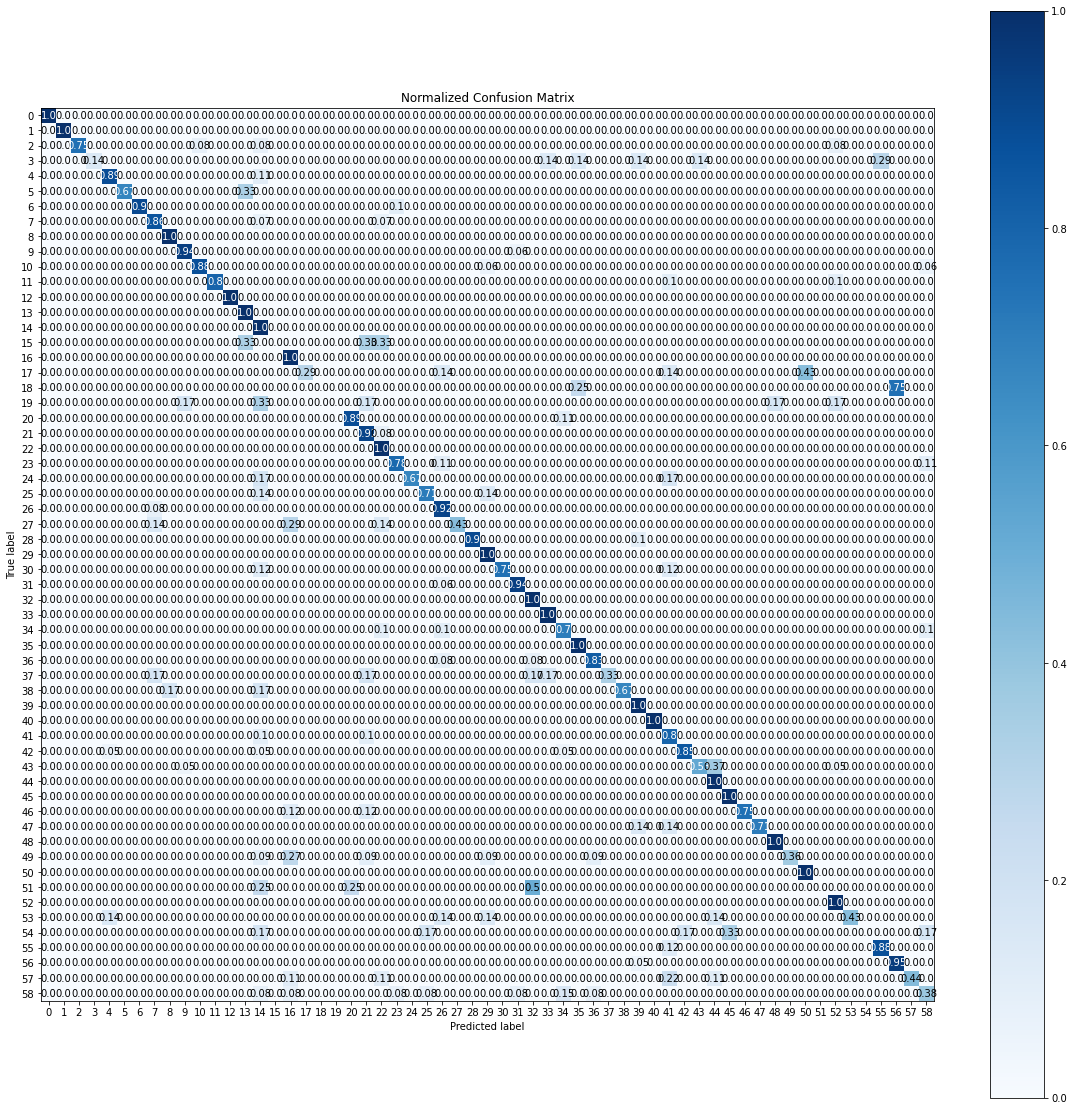

<Figure size 1440x1440 with 0 Axes>

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
skplt.metrics.plot_confusion_matrix(validation_generator.classes, y_pred, normalize=True,ax=ax)
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
model2=Model(model.input,model.layers[-3].output)
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
___________________________________________________________________________________________

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["name_of_the_output_node"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


'kerasFacenet.pb'

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: /tmp/saved-models/assets
x
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_1a_3x3/Conv2D
model_12/Conv2d_1a_3x3_BatchNorm/scale
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3
model_12/Conv2d_1a_3x3_Activation/Relu
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_2a_3x3/Conv2D
model_12/Conv2d_2a_3x3_BatchNorm/scale
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_2a_3x

'/tmp/saved-model/facenet-Original-LastLayer.pb'